In [109]:
import numpy as np

### Correlation utilities (PSD matrix + Cholesky)

These two helper functions are only used to:
- make the correlation matrix numerically stable (symmetric and **positive semi-definite**, PSD),
- compute its **Cholesky factor** (needed to generate correlated Gaussian shocks).



In [110]:
def SymPSD(rho, eps=1e-12):

    rho = np.array(rho, dtype=float)
    rho = 0.5 * (rho + rho.T)

    eigvals, eigvecs = np.linalg.eigh(rho)
    eigvals = np.clip(eigvals, eps, None)
    rho_psd = (eigvecs * eigvals) @ eigvecs.T

    d = np.sqrt(np.diag(rho_psd))
    rho_psd = rho_psd / np.outer(d, d)

    return 0.5 * (rho_psd + rho_psd.T)


def cholesky_corr(rho):
    rho_psd = SymPSD(rho)
    return np.linalg.cholesky(rho_psd)

### Model: simulation of $S_T$

Under the risk-neutral measure $\mathbb{Q}$, each asset $S_t^i$ follows a correlated geometric Brownian motion (GBM):
$$
\frac{dS_t^i}{S_t^i} = r\,dt + \sigma_i\,dW_t^i,
\qquad i=1,\dots,d,
$$

with correlated Brownian motions:
$$
dW_t^i\,dW_t^j = \rho_{ij}\,dt,
$$
where $\rho$ is the $d \times d$ correlation matrix.

For a GBM, we can simulate **directly at maturity** (no time discretization is needed). The terminal value has the closed-form expression:
$$
S_T^i = S_0^i \exp\Big((r-\tfrac12\sigma_i^2)T + \sigma_i\sqrt{T}\,Z_i\Big),
\qquad Z \sim \mathcal{N}(0,\rho).
$$

Implementation steps:
1. Generate $U \sim \mathcal{N}(0, I_d)$ (independent standard normals) for $M$ scenarios.
2. Use a Cholesky factor $L$ such that $\rho = LL^\top$, then build correlated normals $Z = U L^\top$.
3. Apply the GBM terminal formula above to obtain `ST` with shape `(M, d)`.

In [111]:
def simulate_ST_mc(S0, r, sigmas, T, rho, M, seed=0):
 
    rng = np.random.default_rng(seed)

    S0 = np.array(S0, dtype=float)
    sigmas = np.array(sigmas, dtype=float)
    d = S0.size
    assert sigmas.size == d, "sigmas doit avoir la même taille que S0"

    L = cholesky_corr(rho)  # (d,d)

    # 1) gaussiennes iid
    U = rng.standard_normal(size=(M, d))

    # 2) corrélation : Z = U L^T  => Cov(Z)=rho
    Z = U @ L.T

    # 3) formule exacte du GBM
    drift = (r - 0.5 * sigmas**2) * T
    diff = sigmas * np.sqrt(T) * Z
    ST = S0 * np.exp(drift + diff)

    return ST

### Multi-asset payoffs

We implement three basic European payoffs (evaluated at maturity \(T\)):

- **Basket call**: payoff depends on a weighted sum of the assets,
- **Best-of call**: payoff depends on the maximum (best-performing) asset,
- **Spread call (2 assets)**: payoff depends on the difference between two assets.

All functions are vectorized:
- `ST` has shape `(M, d)` (M scenarios, d assets),
- each function returns an array of payoffs of shape `(M,)`, one payoff per scenario.

In [112]:
def payoff_basket_call(ST, w, K):
    ST = np.asarray(ST, dtype=float)
    w = np.asarray(w, dtype=float)
    basket = ST @ w
    return np.maximum(basket - K, 0.0)


def payoff_best_of_call(ST, K):
    ST = np.asarray(ST, dtype=float)
    best = np.max(ST, axis=1)
    return np.maximum(best - K, 0.0)


def payoff_spread_call(ST, K):
    ST = np.asarray(ST, dtype=float)
    assert ST.shape[1] == 2
    spread = ST[:, 0] - ST[:, 1] - K
    return np.maximum(spread, 0.0)

### Monte Carlo pricing + standard error + confidence interval 95%

$$
\widehat{V}_0 = e^{-rT}\,\frac{1}{M}\sum_{m=1}^{M} h\!\left(S_T^{(m)}\right).
$$

In addition to the Monte Carlo price, we report:
- the **standard error (SE)** of the estimator,
- a **95% confidence interval** (normal approximation).

Implementation notes:
- `disc = exp(-r*T)` is the discount factor,
- `mean` is the sample average of the simulated payoffs,
- `var` is the unbiased sample variance (`ddof=1`),
- `se = sqrt(var/M)` is the standard error of the sample mean,
- the 95% CI is `mean ± 1.96 * se`, then discounted by `disc`.

In [113]:
def price_mc_from_payoffs(payoffs, r, T, alpha=0.05):

    payoffs = np.asarray(payoffs, dtype=float)
    M = payoffs.size
    disc = np.exp(-r * T)

    mean = payoffs.mean()
    var = payoffs.var(ddof=1) if M > 1 else 0.0
    se = np.sqrt(var / M) if M > 0 else np.nan

    z = 1.959963984540054

    ci_low = disc * (mean - z * se)
    ci_high = disc * (mean + z * se)

    return disc * mean, disc * se, (ci_low, ci_high)

### Correlation Check


The correlated multi-asset Black–Scholes terminal formula (risk-neutral):

$$
S_T^i = S_0^i \exp\Big((r-\tfrac12\sigma_i^2)T + \sigma_i\sqrt{T}\,Z_i\Big),
\qquad Z \sim \mathcal{N}(0,\rho).
$$

This means:

$$
\ln\!\Big(\frac{S_T^i}{S_0^i}\Big)
= (r-\tfrac12\sigma_i^2)T + \sigma_i\sqrt{T}\,Z_i
\quad\Longrightarrow\quad
Z_i =
\frac{\ln(S_T^i/S_0^i) - (r-\tfrac12\sigma_i^2)T}{\sigma_i\sqrt{T}}.
$$

So we do the following:
1. Simulate terminal prices `ST` of shape `(M, d)`.
2. Reconstruct an "implied" matrix `X` by applying the formula above column-wise.
   Each column of `X` should behave like the corresponding component of `Z`.
3. Compute the empirical correlation matrix of `X`, denoted `rho_emp`.
4. Compare `rho_emp` to the target `rho`. With large enough `M`, they should be close.

Why this check matters:
- it validates the Cholesky correlation step `Z = U @ L.T`,
- it validates the GBM formula used to build `ST`,
- it helps catch common implementation mistakes.


In [114]:
def implied_Z_from_ST(ST, S0, r, sigmas, T):

    ST = np.asarray(ST, dtype=float)
    S0 = np.asarray(S0, dtype=float)
    sigmas = np.asarray(sigmas, dtype=float)
    drift = (r - 0.5 * sigmas**2) * T
    X = (np.log(ST / S0) - drift) / (sigmas * np.sqrt(T))

    return X


def empirical_corr(X):

    X = np.asarray(X, dtype=float)
    Xc = X - X.mean(axis=0, keepdims=True)
    cov = (Xc.T @ Xc) / (X.shape[0] - 1)
    std = np.sqrt(np.diag(cov))
    
    return cov / np.outer(std, std)

In [115]:
from scipy.stats import qmc, norm 

In [116]:
def simulate_ST_sobol(S0, r, sigmas, T, rho, M, seed=0, scramble=True):

    S0 = np.asarray(S0, dtype=float)
    sigmas = np.asarray(sigmas, dtype=float)
    d = S0.size
    assert sigmas.size == d


    engine = qmc.Sobol(d=d, scramble=scramble, seed=seed)

    u = engine.random(n=M)  

    eps = np.finfo(float).eps
    u = np.clip(u, eps, 1.0 - eps)

    y = norm.ppf(u) 


    L = cholesky_corr(rho)     
    z = y @ L.T              

    drift = (r - 0.5 * sigmas**2) * T
    diff = sigmas * np.sqrt(T) * z
    ST = S0 * np.exp(drift + diff)

    return ST

In [117]:
def price_qmc_sobol(
    S0, r, sigmas, T, rho, M,
    payoff_fn, payoff_kwargs,
    R=8, seed=0
):
    prices = []

    for k in range(R):
        ST = simulate_ST_sobol(S0, r, sigmas, T, rho, M, seed=seed + k, scramble=True)
        payoffs = payoff_fn(ST, **payoff_kwargs)
        price, _, _ = price_mc_from_payoffs(payoffs, r, T) 
        prices.append(price)

    prices = np.asarray(prices, dtype=float)
    mean_price = prices.mean()

    se = prices.std(ddof=1) / np.sqrt(R) if R > 1 else np.nan

    z = 1.959963984540054  
    ci = (mean_price - z * se, mean_price + z * se)

    return mean_price, se, ci, prices

### Experiment setup (parameters and inputs)

In [118]:
S0 = [100, 95, 105]
sigmas = [0.20, 0.25, 0.18]
r = 0.02
K = 100
rho = np.array([
    [1.0, 0.6, 0.3],
    [0.6, 1.0, 0.4],
    [0.3, 0.4, 1.0],
])
M = 200_000
seed = 42

### Price as a function of maturity \(T\): MC vs QMC (Sobol)

In this section we compute the option price for a range of maturities \(T\) and compare:
- **Monte Carlo (MC)** using pseudo-random Gaussian draws,
- **Quasi–Monte Carlo (QMC)** using **scrambled Sobol** points.

For each maturity \(T\), both methods estimate the discounted expected payoff:
$$
\widehat{V}_0(T) = e^{-rT}\,\frac{1}{M}\sum_{m=1}^{M} h\!\left(S_T^{(m)}\right).
$$

To obtain a smoother curve when plotting price vs maturity, we optionally use **common random numbers**:
- For MC, we generate the correlated Gaussian shocks once and reuse them for all \(T\).
- For QMC, we generate Sobol base points once per replication and reuse them for all \(T\).
This reduces the visual noise and makes the effect of changing \(T\) easier to interpret.

### Inputs
- `T_grid`: list/array of maturities to evaluate,
- `payoff_fn` + `payoff_kwargs`: payoff definition (basket, best-of, spread, ...),
- `M_mc`: number of MC scenarios per maturity,
- `M_qmc`: number of QMC Sobol points per maturity (often chosen as a power of two, e.g. \(2^{15}\)),
- `R`: number of scrambled Sobol replications (used to estimate a standard error / confidence interval for QMC),
- `rho`: correlation matrix, plus model parameters `S0`, `r`, `sigmas`.

### Outputs
For each maturity \(T\), we return:
- `mc_price[T]`, `mc_se[T]`, `mc_ci[T]` (MC price, standard error, 95% CI),
- `qmc_price[T]`, `qmc_se[T]`, `qmc_ci[T]` (QMC price, SE across replications, 95% CI).

Finally, we plot **MC vs QMC price curves** as a function of maturity.

/var/folders/cw/dmc29yl132b0gt9jmntgvzlc0000gn/T/ipykernel_79733/1351939008.py:25: RuntimeWarning: divide by zero encountered in matmul
  Z_mc = U_mc @ L.T
/var/folders/cw/dmc29yl132b0gt9jmntgvzlc0000gn/T/ipykernel_79733/1351939008.py:25: RuntimeWarning: overflow encountered in matmul
  Z_mc = U_mc @ L.T
/var/folders/cw/dmc29yl132b0gt9jmntgvzlc0000gn/T/ipykernel_79733/1351939008.py:25: RuntimeWarning: invalid value encountered in matmul
  Z_mc = U_mc @ L.T
/var/folders/cw/dmc29yl132b0gt9jmntgvzlc0000gn/T/ipykernel_79733/1256997397.py:4: RuntimeWarning: divide by zero encountered in matmul
  basket = ST @ w
/var/folders/cw/dmc29yl132b0gt9jmntgvzlc0000gn/T/ipykernel_79733/1256997397.py:4: RuntimeWarning: overflow encountered in matmul
  basket = ST @ w
/var/folders/cw/dmc29yl132b0gt9jmntgvzlc0000gn/T/ipykernel_79733/1256997397.py:4: RuntimeWarning: invalid value encountered in matmul
  basket = ST @ w
/var/folders/cw/dmc29yl132b0gt9jmntgvzlc0000gn/T/ipykernel_79733/1351939008.py:65: Runt

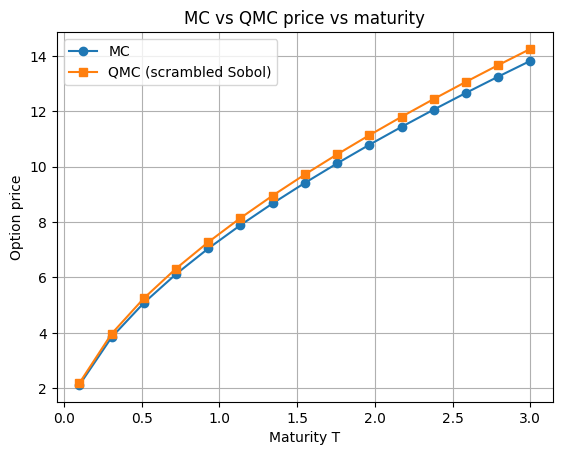

In [119]:
import numpy as np
import matplotlib.pyplot as plt

def compare_mc_qmc_vs_maturity(
    S0, r, sigmas, rho,
    payoff_fn, payoff_kwargs,
    T_grid,
    M_mc=1000,
    M_qmc=2**15,
    R=8,
    seed_mc=42,
    seed_qmc=123,
    common_random_numbers=True
):

    S0 = np.asarray(S0, dtype=float)
    sigmas = np.asarray(sigmas, dtype=float)
    d = S0.size


    if common_random_numbers:
        rng = np.random.default_rng(seed_mc)
        L = cholesky_corr(rho)
        U_mc = rng.standard_normal((M_mc, d))
        Z_mc = U_mc @ L.T
    else:
        Z_mc = None


    if common_random_numbers:
        L = cholesky_corr(rho)
        sobol_engine = qmc.Sobol(d=d, scramble=True, seed=seed_qmc)
   
        u_reps = []
        eps = np.finfo(float).eps
        for k in range(R):
            eng = qmc.Sobol(d=d, scramble=True, seed=seed_qmc + k)
            u = eng.random(n=M_qmc)
            u = np.clip(u, eps, 1.0 - eps)
            u_reps.append(u)
    else:
        u_reps = None

    mc_prices, mc_ses, mc_cis = [], [], []
    qmc_prices, qmc_ses, qmc_cis = [], [], []

    for T in T_grid:

        if common_random_numbers:
            drift = (r - 0.5 * sigmas**2) * T
            diff = sigmas * np.sqrt(T) * Z_mc
            ST_mc = S0 * np.exp(drift + diff)
        else:
            ST_mc = simulate_ST_mc(S0, r, sigmas, T, rho, M_mc, seed=seed_mc)

        pay_mc = payoff_fn(ST_mc, **payoff_kwargs)
        price_mc, se_mc, ci_mc = price_mc_from_payoffs(pay_mc, r, T)
        mc_prices.append(price_mc); mc_ses.append(se_mc); mc_cis.append(ci_mc)

        rep_prices = []
        for k in range(R):
            if common_random_numbers:
                u = u_reps[k]
                y = norm.ppf(u)        
                z = y @ cholesky_corr(rho).T 
                drift = (r - 0.5 * sigmas**2) * T
                diff = sigmas * np.sqrt(T) * z
                ST_q = S0 * np.exp(drift + diff)
            else:
                ST_q = simulate_ST_sobol(S0, r, sigmas, T, rho, M_qmc, seed=seed_qmc + k, scramble=True)

            pay_q = payoff_fn(ST_q, **payoff_kwargs)
            p_q, _, _ = price_mc_from_payoffs(pay_q, r, T)
            rep_prices.append(p_q)

        rep_prices = np.asarray(rep_prices)
        p_mean = rep_prices.mean()
        se_rep = rep_prices.std(ddof=1) / np.sqrt(R) if R > 1 else np.nan
        z95 = 1.959963984540054
        ci = (p_mean - z95 * se_rep, p_mean + z95 * se_rep)

        qmc_prices.append(p_mean); qmc_ses.append(se_rep); qmc_cis.append(ci)

    return (
        np.asarray(mc_prices), np.asarray(mc_ses), np.asarray(mc_cis),
        np.asarray(qmc_prices), np.asarray(qmc_ses), np.asarray(qmc_cis)
    )


T_grid = np.linspace(0.1, 3.0, 15)

mc_prices, mc_ses, mc_cis, qmc_prices, qmc_ses, qmc_cis = compare_mc_qmc_vs_maturity(
    S0=S0, r=r, sigmas=sigmas, rho=rho,
    payoff_fn=payoff_basket_call,
    payoff_kwargs={"w": np.ones(len(S0))/len(S0), "K": K},
    T_grid=T_grid,
    M_mc=1000,
    M_qmc=2**15,
    R=8,
    seed_mc=42,
    seed_qmc=123,
    common_random_numbers=True
)

plt.figure()
plt.plot(T_grid, mc_prices, marker="o", label="MC")
plt.plot(T_grid, qmc_prices, marker="s", label="QMC (scrambled Sobol)")
plt.xlabel("Maturity T")
plt.ylabel("Option price")
plt.title("MC vs QMC price vs maturity")
plt.grid(True)
plt.legend()
plt.show()

### Error vs maturity T (MC vs QMC)


/var/folders/cw/dmc29yl132b0gt9jmntgvzlc0000gn/T/ipykernel_79733/3764494048.py:16: RuntimeWarning: divide by zero encountered in matmul
  Z = U @ L.T
/var/folders/cw/dmc29yl132b0gt9jmntgvzlc0000gn/T/ipykernel_79733/3764494048.py:16: RuntimeWarning: overflow encountered in matmul
  Z = U @ L.T
/var/folders/cw/dmc29yl132b0gt9jmntgvzlc0000gn/T/ipykernel_79733/3764494048.py:16: RuntimeWarning: invalid value encountered in matmul
  Z = U @ L.T
/var/folders/cw/dmc29yl132b0gt9jmntgvzlc0000gn/T/ipykernel_79733/1256997397.py:4: RuntimeWarning: divide by zero encountered in matmul
  basket = ST @ w
/var/folders/cw/dmc29yl132b0gt9jmntgvzlc0000gn/T/ipykernel_79733/1256997397.py:4: RuntimeWarning: overflow encountered in matmul
  basket = ST @ w
/var/folders/cw/dmc29yl132b0gt9jmntgvzlc0000gn/T/ipykernel_79733/1256997397.py:4: RuntimeWarning: invalid value encountered in matmul
  basket = ST @ w
/var/folders/cw/dmc29yl132b0gt9jmntgvzlc0000gn/T/ipykernel_79733/601346228.py:20: RuntimeWarning: divide 

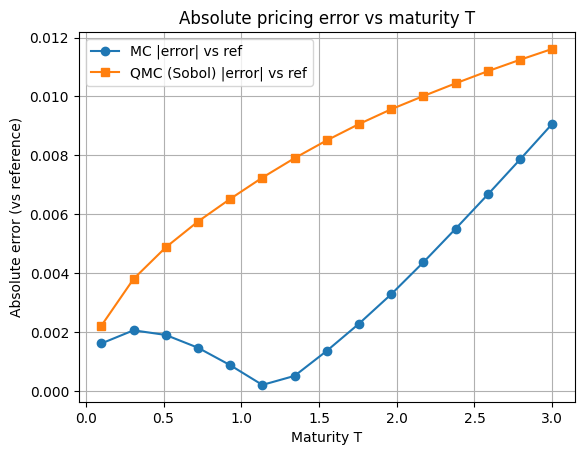

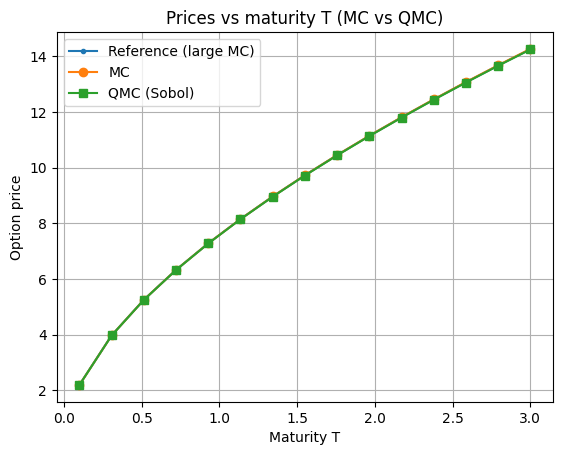

In [120]:
import numpy as np
import matplotlib.pyplot as plt

def price_mc_T(S0, r, sigmas, rho, M, payoff_fn, payoff_kwargs, T_grid, seed=0):
    prices = []
    ses = []
    for T in T_grid:
        ST = simulate_ST_mc(S0, r, sigmas, T, rho, M, seed=seed)
        pay = payoff_fn(ST, **payoff_kwargs)
        p, se, _ = price_mc_from_payoffs(pay, r, T)
        prices.append(p); ses.append(se)
    return np.array(prices), np.array(ses)

def price_qmc_T(S0, r, sigmas, rho, M, payoff_fn, payoff_kwargs, T_grid, R=8, seed=0):
    prices = []
    ses = []
    for T in T_grid:
        p, se, _, _ = price_qmc_sobol(
            S0, r, sigmas, T, rho, M,
            payoff_fn=payoff_fn, payoff_kwargs=payoff_kwargs,
            R=R, seed=seed
        )
        prices.append(p); ses.append(se)
    return np.array(prices), np.array(ses)

def error_vs_T(
    S0, r, sigmas, rho,
    payoff_fn, payoff_kwargs,
    T_grid,
    M_mc=200_000,
    M_qmc=2**15,
    R=8,
    M_ref=1_000_000,
    seed_ref=999,
    seed_mc=42,
    seed_qmc=123
):
    V_ref, se_ref = price_mc_T(S0, r, sigmas, rho, M_ref, payoff_fn, payoff_kwargs, T_grid, seed=seed_ref)

    V_mc, se_mc = price_mc_T(S0, r, sigmas, rho, M_mc, payoff_fn, payoff_kwargs, T_grid, seed=seed_mc)

    V_qmc, se_qmc = price_qmc_T(S0, r, sigmas, rho, M_qmc, payoff_fn, payoff_kwargs, T_grid, R=R, seed=seed_qmc)

    err_mc = np.abs(V_mc - V_ref)
    err_qmc = np.abs(V_qmc - V_ref)

    return V_ref, V_mc, V_qmc, err_mc, err_qmc, se_mc, se_qmc



T_grid = np.linspace(0.1, 3.0, 15)
w = np.ones(len(S0)) / len(S0)
payoff_kwargs = {"w": w, "K": K}

V_ref, V_mc, V_qmc, err_mc, err_qmc, se_mc, se_qmc = error_vs_T(
    S0=S0, r=r, sigmas=sigmas, rho=rho,
    payoff_fn=payoff_basket_call, payoff_kwargs=payoff_kwargs,
    T_grid=T_grid,
    M_mc=50_000,
    M_qmc=2**14,
    R=8,
    M_ref=500_000
)

plt.figure()
plt.plot(T_grid, err_mc, marker="o", label="MC |error| vs ref")
plt.plot(T_grid, err_qmc, marker="s", label="QMC (Sobol) |error| vs ref")
plt.xlabel("Maturity T")
plt.ylabel("Absolute error (vs reference)")
plt.title("Absolute pricing error vs maturity T")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(T_grid, V_ref, marker=".", label="Reference (large MC)")
plt.plot(T_grid, V_mc, marker="o", label="MC")
plt.plot(T_grid, V_qmc, marker="s", label="QMC (Sobol)")
plt.xlabel("Maturity T")
plt.ylabel("Option price")
plt.title("Prices vs maturity T (MC vs QMC)")
plt.grid(True)
plt.legend()
plt.show()